In [95]:
# Prepare all imports, write relevant functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

def melt_data(df):
    melted = pd.melt(df, id_vars=['CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})


def eval_arima(ts,order):
    train_len=int(.8*len(ts))
    ts_train=ts[:train_len]
    ts_test=ts[train_len:]
    
    history=[x for x in ts_train]
    predictions=[]
    
    for t in range(len(ts_test)):
        model=ARIMA(history,order=order)
        model_fit=model.fit(disp=0)
        yhat=model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(ts_test[t])
    error=mean_squared_error(ts_test,predictions)
    return error


def arima_gridsearch(ts,Pvec,Dvec,Qvec):
    Best_score,Best_pdq=float('inf'),None
    for p in Pvec:
        for d in Dvec:
            for q in Qvec:
                order=(p,d,q)
                try:
                    mse=eval_arima(ts,order)
                    if mse<Best_score:
                        Best_score,Best_pdq=mse,order
                    print(f"Arima{order} MSE={mse}")
                except:
                    continue
    return Best_pdq

In [63]:
#Prepare and clean data

url=r'C:\Users\dkond\Desktop\zillow_data.csv'
data=pd.read_csv(url)

data.rename(columns={'RegionName':'Zip'},inplace=True)

data.index=data.Zip
data.drop(['RegionID','SizeRank','Zip'],axis=1,inplace=True)

data.head()

,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
Zip,,,,,,,,,,,,,,,,,,,,,
60657,Chicago,IL,Chicago,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
75070,McKinney,TX,Dallas-Fort Worth,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
77494,Katy,TX,Houston,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
60614,Chicago,IL,Chicago,Cook,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
79936,El Paso,TX,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [77]:
#For the sake of tractability, only NYC zipcodes will be considered
df=data[data.City=='New York']
df.drop(['City','State','Metro'],axis=1,inplace=True)
df.head(10)

,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
Zip,,,,,,,,,,,,,,,,,,,,,
10467,Bronx,152900.0,152700.0,152600.0,152400.0,152300.0,152000.0,151800.0,151600.0,151600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
11226,Kings,162000.0,162300.0,162600.0,163000.0,163400.0,164000.0,164700.0,165700.0,166800.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
11375,Queens,252400.0,251800.0,251400.0,251200.0,251100.0,251000.0,251000.0,251200.0,251700.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
11235,Kings,190500.0,191000.0,191500.0,192000.0,192500.0,193000.0,193600.0,194300.0,195300.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
10011,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300
10128,New York,3676700.0,3704200.0,3729600.0,3754600.0,3781800.0,3813500.0,3849600.0,3888900.0,3928800.0,...,7410100,7422400,7417600,7427300,7371400,7342700,7353300,7350300,7363000,7386600
10462,Bronx,154300.0,154300.0,154400.0,154400.0,154500.0,154400.0,154500.0,154500.0,154800.0,...,432800,436100,439900,443500,444100,443900,446000,446400,447200,450200
10456,Bronx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,357900,357100,356500,357200,362000,368500,374100,379800,388100,394400
10463,Bronx,180100.0,181000.0,181900.0,182600.0,183200.0,183700.0,184400.0,185100.0,186100.0,...,680800,684500,692000,700900,710200,726900,744500,757000,769400,778700


In [65]:
df.CountyName.value_counts()

Queens      55
Kings       28
Bronx       13
Richmond    12
New York     6
Name: CountyName, dtype: int64

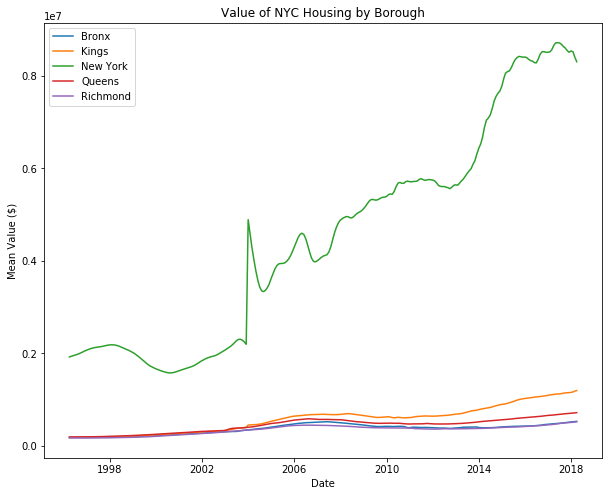

In [66]:
#Let's check out the different boroughs. I hear Queens is the most popular tourist destination in the world!
df.CountyName.value_counts()

Borough_df=df.groupby('CountyName')

plt.figure(figsize=(10,8))
plt.xlabel('Date')
plt.ylabel('Mean Value ($)')
plt.title('Value of NYC Housing by Borough')

for key,borough in Borough_df:
    plt.plot(melt_data(borough),label=key)
    plt.legend()
plt.show()

#As one might expect, houses in Manhattan are, on average, FAR more valuable that those in other boroughs

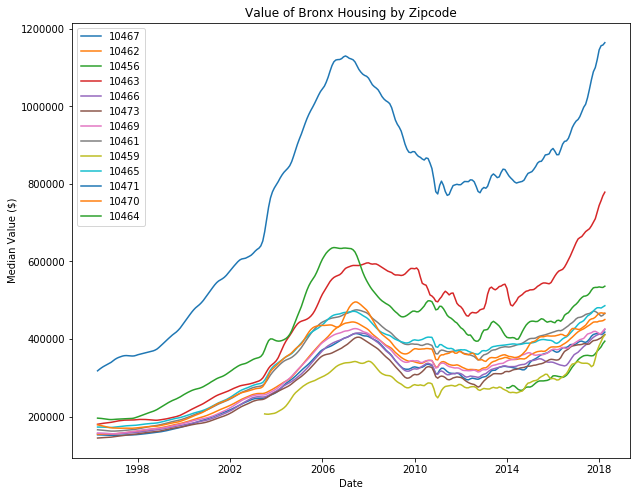

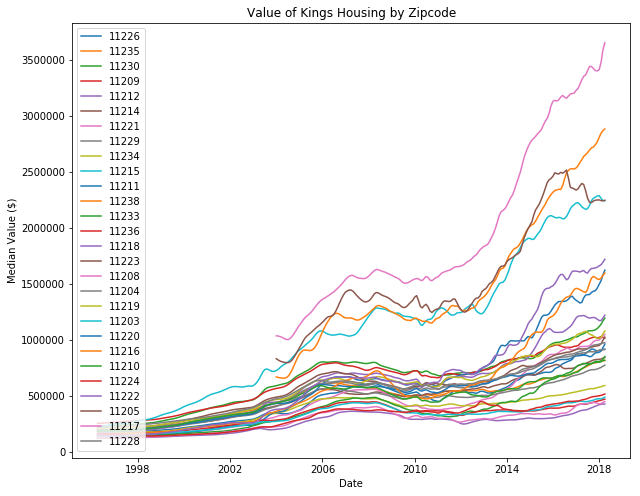

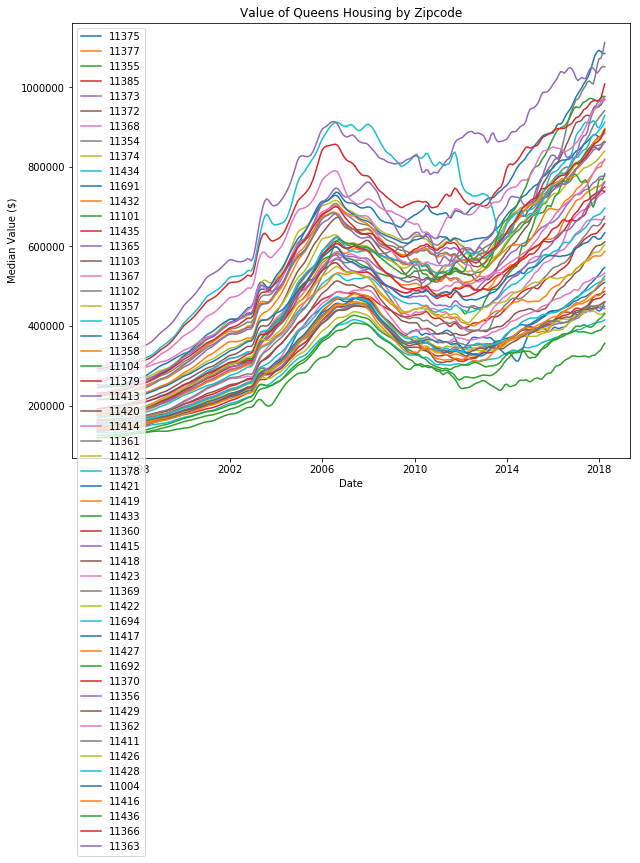

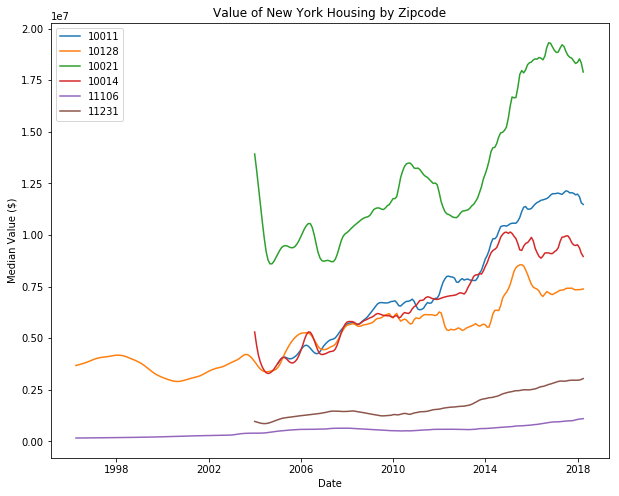

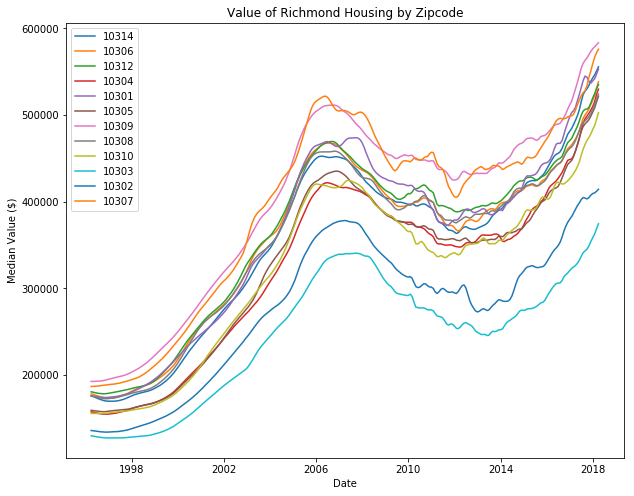

In [73]:
#Lets make a plot of each zip in each borough

for county in df.CountyName.unique():
    plt.figure(figsize=(10,8))
    plt.xlabel('Date')
    plt.ylabel('Median Value ($)')
    plt.title(f'Value of {county} Housing by Zipcode')
    
    temp_df=df[df.CountyName==county]
    for ind in temp_df.index:
        melt_df=melt_data(temp_df[temp_df.index==ind])
        plt.plot(melt_df,label=ind)
        plt.legend()
    plt.show()

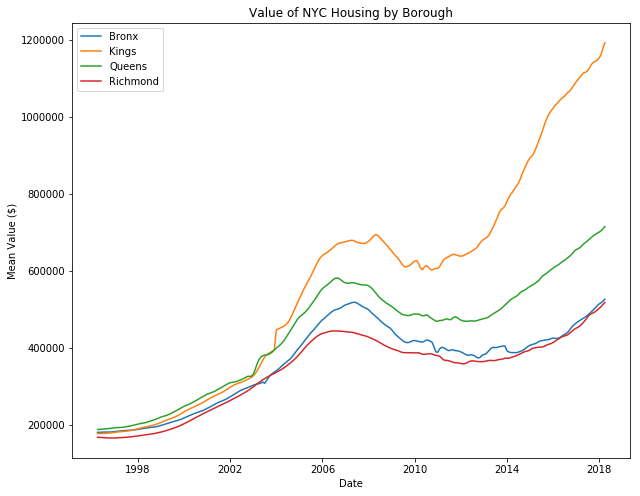

In [78]:
#Wowee! Not what I expected! Keep in mind we are looking for return on investment
#which means that we are less interested in absolute price as opposed to
#how much we think the value will grow

#based on the graphs, Manhattan is stagnant, while Brooklyn,Queens the Bronx and Staten Island (Im just as surprised as you)
#are rapidly appreciating in value.

df=df[df.CountyName.isin(['Richmond','Kings','Bronx','Queens'])]

Borough_df=df.groupby('CountyName')

plt.figure(figsize=(10,8))
plt.xlabel('Date')
plt.ylabel('Mean Value ($)')
plt.title('Value of NYC Housing by Borough')

for key,borough in Borough_df:
    plt.plot(melt_data(borough),label=key)
    plt.legend()
plt.show()

In [99]:
#Even though the graphs looked flat when plotted against Manhattan, they are clearly skyrocketing in value!
#Additionally, Manhattan flatlined and even sank over the last few years while these boroughs did not


#lets do a trial run


ts=melt_data(df[df.index==11224])

print(eval_arima(ts.values,[0,0,0]))

print(arima_gridsearch(ts.values,range(0,3),range(0,3),range(0,3)))

21247920544.22789
Arima(0, 0, 0) MSE=21247920544.22789
Arima(0, 0, 1) MSE=5424885648.878994
Arima(0, 1, 0) MSE=10692968.45202281
Arima(0, 1, 1) MSE=4594052.835887428
Arima(0, 2, 0) MSE=4428448.912869084
Arima(0, 2, 1) MSE=3530647.715251517
Arima(1, 0, 0) MSE=15439745.098105665
Arima(1, 1, 0) MSE=3691930.858328352
Arima(1, 1, 2) MSE=2410623.833824955
Arima(1, 2, 0) MSE=4521365.86678485
Arima(1, 2, 1) MSE=3570338.090775657
Arima(2, 0, 0) MSE=4142104.1123280283
Arima(2, 1, 0) MSE=3888812.082999316
Arima(2, 1, 1) MSE=3065669.7805695916
Arima(2, 1, 2) MSE=2147555.500543937
Arima(2, 2, 0) MSE=3069265.5532744117
Arima(2, 2, 1) MSE=2870553.321821757
Arima(2, 2, 2) MSE=3245686.333616468
(2, 1, 2)


In [102]:
#This took far too long. For the sake of time I will only look at Brooklyn zipcodes
#A future project may be to look at the ROI of other boroughs (and other cities at that)
print(df.CountyName.value_counts())
Brooklyn_df=df[df.CountyName=='Kings']

Queens      55
Kings       28
Bronx       13
Richmond    12
Name: CountyName, dtype: int64


In [105]:
P=D=Q=range(0,4) #It is very unlikely any term in the order is greater than 3

Order_dict=dict() #Will store ARIMA best order results for each zipcode
count=0
for zipcode in Brooklyn_df.index:
    ts=melt_data(Brooklyn_df[Brooklyn_df.index==zipcode])
    print(count,zipcode)
    count+=1
    Best_pdq=arima_gridsearch(ts.values,P,D,Q)
    Order_dict[zipcode]=Best_pdq


0 11226
Arima(0, 0, 0) MSE=121696194659.11151
Arima(0, 0, 1) MSE=31186300678.301197
Arima(0, 1, 0) MSE=96778360.04679437
Arima(0, 1, 1) MSE=48470984.69031
Arima(0, 2, 0) MSE=45403219.886162706
Arima(0, 2, 1) MSE=42904975.461784504
Arima(0, 2, 2) MSE=40751224.48980025
Arima(1, 0, 0) MSE=128365891.08922462
Arima(1, 1, 0) MSE=43390998.94341448
Arima(1, 1, 1) MSE=37058761.60654213
Arima(1, 1, 2) MSE=38780547.24945443
Arima(1, 2, 0) MSE=44619623.66798633
Arima(1, 2, 1) MSE=42578565.878526635
Arima(2, 1, 0) MSE=39127764.46713043
Arima(2, 1, 1) MSE=37368958.2930101
Arima(2, 1, 2) MSE=29481718.137091152
Arima(2, 2, 0) MSE=37310499.5723498
Arima(2, 2, 1) MSE=38157928.26058514
Arima(3, 1, 0) MSE=35842904.84550509
Arima(3, 1, 1) MSE=36495843.908317484
Arima(3, 2, 0) MSE=37960819.8597606
Arima(3, 2, 1) MSE=38323405.74774043
1 11235
Arima(0, 0, 0) MSE=55319673787.18492
Arima(0, 0, 1) MSE=14155542463.756626
Arima(0, 1, 0) MSE=19663226.331772942
Arima(0, 1, 1) MSE=7740655.781911764
Arima(0, 2, 0) MSE

Arima(1, 0, 0) MSE=11039559.630238328
Arima(1, 1, 0) MSE=2038571.3076773565
Arima(1, 1, 2) MSE=1728571.1018432362
Arima(1, 1, 3) MSE=1234298.4005567436
Arima(1, 2, 0) MSE=2460690.6183167933
Arima(1, 2, 1) MSE=2305158.1129225115
Arima(1, 2, 2) MSE=1891741.5972378107
Arima(1, 2, 3) MSE=1257352.966711027
Arima(2, 0, 0) MSE=2169293.1613698853
Arima(2, 0, 1) MSE=2047872.3282621824
Arima(2, 0, 2) MSE=1979417.9748112708
Arima(2, 1, 0) MSE=2187040.070685662
Arima(2, 1, 1) MSE=2032600.4321756246
Arima(2, 1, 2) MSE=1400949.9594673421
Arima(2, 1, 3) MSE=1233702.826186602
Arima(2, 2, 0) MSE=2045841.0612169155
Arima(2, 2, 1) MSE=2010691.8346266206
Arima(2, 2, 2) MSE=1904250.6242175635
Arima(2, 2, 3) MSE=1262610.6838570347
Arima(3, 0, 0) MSE=2358731.5343327248
Arima(3, 0, 1) MSE=2153914.670883834
Arima(3, 0, 2) MSE=1517658.3653238383
Arima(3, 1, 0) MSE=1956447.9385381732
Arima(3, 1, 1) MSE=1898891.63463714
Arima(3, 1, 2) MSE=1699434.3441470207
Arima(3, 1, 3) MSE=1296356.6617719668
Arima(3, 2, 0) MSE

Arima(2, 1, 0) MSE=6053573.184440909
Arima(2, 1, 1) MSE=4081526.736899925
Arima(2, 1, 2) MSE=3742343.1771230237
Arima(2, 1, 3) MSE=3737547.755261012
Arima(2, 2, 0) MSE=4441502.566113928
Arima(2, 2, 1) MSE=4033545.993164927
Arima(2, 2, 2) MSE=4122696.2668431667
Arima(2, 2, 3) MSE=3853485.0568182124
Arima(3, 0, 0) MSE=6294923.664099618
Arima(3, 0, 1) MSE=4204392.092939245
Arima(3, 0, 2) MSE=3838711.064971047
Arima(3, 0, 3) MSE=3813264.247435802
Arima(3, 1, 0) MSE=4226265.4426351385
Arima(3, 1, 1) MSE=3724336.127424215
Arima(3, 1, 2) MSE=3780153.106438477
Arima(3, 1, 3) MSE=3727100.527861202
Arima(3, 2, 0) MSE=4287444.377096502
Arima(3, 2, 1) MSE=4093563.5315467166
Arima(3, 2, 3) MSE=3856219.753434656
17 11204
Arima(0, 0, 0) MSE=124040181476.98445
Arima(0, 0, 1) MSE=31569297488.147564
Arima(0, 1, 0) MSE=17775719.06217834
Arima(0, 1, 1) MSE=5985359.5093072755
Arima(0, 2, 0) MSE=4138779.592562235
Arima(0, 2, 1) MSE=3159529.5356880855
Arima(1, 0, 0) MSE=41591499.94985295
Arima(1, 1, 0) MSE=3

Arima(2, 1, 0) MSE=146476815.50119448
Arima(2, 1, 1) MSE=114005787.08657348
Arima(2, 1, 3) MSE=98801437.27175513
Arima(2, 2, 0) MSE=130659683.02398916
Arima(2, 2, 1) MSE=131383084.47560273
Arima(2, 2, 2) MSE=115271629.74417476
Arima(3, 1, 0) MSE=122399327.7924739
Arima(3, 1, 1) MSE=112569201.60469192
Arima(3, 1, 3) MSE=98999817.55202806
Arima(3, 2, 0) MSE=132658426.91098413
25 11205
Arima(0, 0, 0) MSE=817695958628.1167
Arima(0, 0, 1) MSE=203685287805.32797
Arima(0, 1, 0) MSE=1070438048.7747535
Arima(0, 1, 1) MSE=419808756.8585868
Arima(0, 2, 0) MSE=696935805.1344458
Arima(0, 2, 1) MSE=579148477.6244304
Arima(1, 0, 0) MSE=1010410729.7077329
Arima(1, 1, 0) MSE=607264061.8284998
Arima(1, 1, 3) MSE=442660505.59320366
Arima(1, 2, 0) MSE=713702504.7655709
Arima(1, 2, 1) MSE=561334546.696652
Arima(2, 0, 0) MSE=619516889.4435079
Arima(2, 1, 0) MSE=581298680.2104173
Arima(2, 2, 0) MSE=590454642.5735966
Arima(2, 2, 1) MSE=510817860.5377538
Arima(3, 1, 0) MSE=535690048.5819482
Arima(3, 1, 1) MSE=

In [106]:
for key,val in Order_dict.items():
    print(key,val)
    


11226 (2, 1, 2)
11235 (1, 1, 3)
11230 (2, 2, 3)
11209 (3, 1, 2)
11212 (2, 1, 2)
11214 (2, 1, 2)
11221 (1, 2, 3)
11229 (1, 1, 3)
11234 (2, 1, 3)
11215 (2, 2, 3)
11211 (1, 1, 3)
11238 (2, 1, 0)
11233 (3, 1, 0)
11236 (1, 1, 3)
11218 (2, 1, 2)
11223 (1, 1, 3)
11208 (1, 1, 3)
11204 (3, 1, 3)
11219 (3, 1, 2)
11203 (0, 2, 3)
11220 (2, 1, 2)
11216 (1, 1, 2)
11210 (2, 1, 2)
11224 (3, 1, 3)
11222 (2, 1, 3)
11205 (0, 1, 1)
11217 (2, 1, 3)
11228 (2, 1, 3)


In [126]:
#due to error, one of the values must be changed
Order_dict[11203]=(1,1,3)


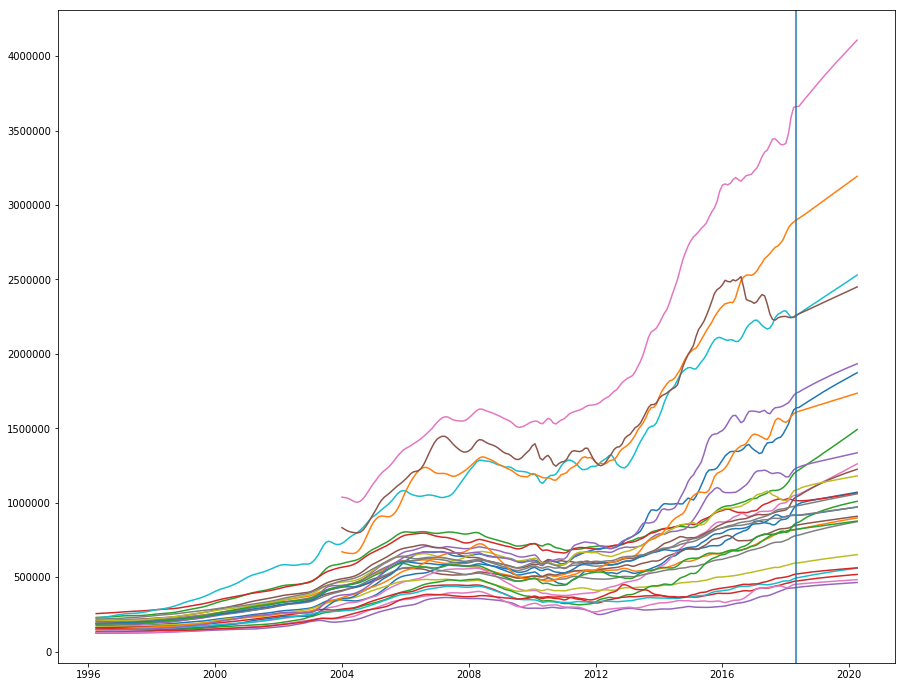

In [129]:
future=pd.date_range(start = '2018-05-01', end = '2020-04-01', freq = 'MS')
plt.figure(figsize=(15,12))

Forecast_dict={}

for key,val in Order_dict.items():
    ts=melt_data(Brooklyn_df[Brooklyn_df.index==key])
    model=ARIMA(ts,order=val)
    model_fit=model.fit(disp=0)
    forecast=model_fit.forecast(24)
    forecast_df=pd.DataFrame({'time':future,'value':forecast[0]})
    forecast_df.set_index('time', inplace = True)
    ts_forecast=pd.concat([ts,forecast_df])
    Forecast_dict[key]=ts_forecast
    plt.plot(ts_forecast)
    

plt.axvline(x='2018-05-01')
plt.show()
    
    

In [152]:
#Cool, so now we have the graphs and we can see that most trends continued just as expected
#Lets calculate the ROIS



ROI=dict()

for zipcode,ts in Forecast_dict.items():
    Start=float(ts[ts.index=='2018-04-01'].value)
    End=float(ts[ts.index=='2020-04-01'].value)
    Percent_Increase=(End-Start)*100/Start
    ROI[zipcode]=Percent_Increase

sorted_ROI=sorted(ROI.items(), key=lambda x: x[1], reverse=True)
sorted_ROI


[(11230, 24.777579665143215),
 (11221, 20.27378325635945),
 (11223, 19.34239499889709),
 (11233, 18.499300396062605),
 (11211, 15.361484159987594),
 (11203, 14.558539062319214),
 (11215, 12.726588907941327),
 (11229, 12.614765704431235),
 (11222, 12.349180116183833),
 (11217, 12.335102963199228),
 (11226, 11.180338430008991),
 (11238, 10.651168615563128),
 (11235, 10.068170333569787),
 (11236, 9.968252288244214),
 (11234, 9.869591502156378),
 (11218, 9.395878218875438),
 (11219, 9.37716956374251),
 (11205, 8.952406569377475),
 (11224, 8.728973231554821),
 (11216, 8.580453609753787),
 (11204, 8.557909096418983),
 (11212, 8.479163338594848),
 (11214, 7.747499291804177),
 (11208, 7.379625449159508),
 (11210, 7.031509315265557),
 (11228, 6.128596024120449),
 (11220, 5.882324792164746),
 (11209, 4.808695618715197)]

In [157]:
#The top 5 zipcodes to invest in, which will be worth the most in the next 2 years are:
# 11230, 11221, 11223,11233,11211
#How about the zop 5 zipcodes for every five years up to 50 years from now?


for years in [5*i for i in range(1,11)]:
    future=pd.date_range(start = '2018-05-01', periods= 12*years, freq = 'MS')
    
    ROIs=dict()
    
    for key,val in Order_dict.items():
        ts=melt_data(Brooklyn_df[Brooklyn_df.index==key])
        Start_val=float(ts[ts.index=='2018-04-01'].value)
        model=ARIMA(ts,order=val)
        model_fit=model.fit(disp=0)
        forecast=model_fit.forecast(12*years)
        forecast_df=pd.DataFrame({'time':future,'value':forecast[0]})
        forecast_df.set_index('time', inplace = True)
        ts_forecast=pd.concat([ts,forecast_df])
        End_val=float(ts_forecast.iloc[-1])
        roi=100*(End_val-Start_val)/Start_val
        ROIs[key]=roi
    sorted_ROI=sorted(ROIs.items(), key=lambda x: x[1], reverse=True)
    Top5=[x[0] for x in sorted_ROI[:5]]
    print(f'In {years} years, the most valuable zipcodes will be {Top5}')


In 5 years, the most valuable zipcodes will be [11230, 11221, 11223, 11211, 11215]
In 10 years, the most valuable zipcodes will be [11230, 11221, 11215, 11211, 11223]
In 15 years, the most valuable zipcodes will be [11230, 11221, 11215, 11238, 11217]
In 20 years, the most valuable zipcodes will be [11230, 11221, 11215, 11238, 11217]
In 25 years, the most valuable zipcodes will be [11230, 11221, 11215, 11238, 11217]
In 30 years, the most valuable zipcodes will be [11230, 11221, 11215, 11238, 11217]
In 35 years, the most valuable zipcodes will be [11230, 11221, 11215, 11238, 11217]
In 40 years, the most valuable zipcodes will be [11230, 11221, 11215, 11238, 11217]
In 45 years, the most valuable zipcodes will be [11230, 11221, 11215, 11238, 11217]
In 50 years, the most valuable zipcodes will be [11230, 11221, 11215, 11238, 11217]
